# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

In [1]:
# Библиотеки
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, cv, train
from lightgbm import LGBMRegressor
import time


In [2]:
try:
    data = pd.read_csv('C:/Users/Ксения/data_analyst/авто_подбор_цены/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.columns = data.columns.str.lower()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# Удалим ненужные столбцы
data = data.drop(['datecrawled', 'registrationmonth', 'datecreated'
                  , 'numberofpictures', 'postalcode', 'lastseen'], axis = 1).reset_index(drop=True)

Пропуски


price                   0
vehicletype         37490
registrationyear        0
gearbox             19833
power                   0
model               19705
kilometer               0
fueltype            32895
brand                   0
repaired            71154
dtype: int64

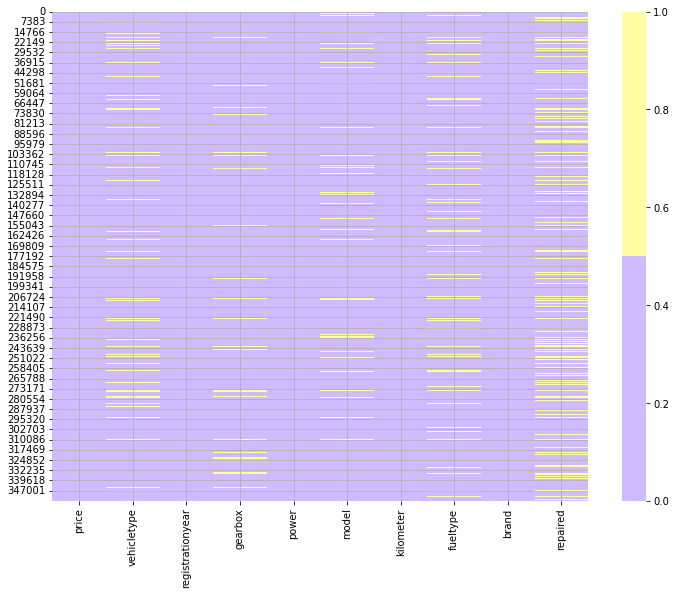

In [7]:
# Посмотрим на пропуски в датасете
colours = ['#D0BBFF', '#FFFEA3'] 
fig, ax = plt.subplots(figsize=(12,9))
print('Пропуски')
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))
plt.grid()
data.isna().sum()

Пропуски имеем в столбце:
- тип автомобильного кузова
- тип коробки передач
- модель автомобиля
- тип топлива
- ремонт

In [8]:
# Заменим пропуски на "нет данных"
data['repaired']=data['repaired'].fillna('nda')

In [9]:
# заменим пропуски на самое популярное топливо
data['fueltype'] = data['fueltype'].fillna(data['fueltype'].value_counts(ascending=False).index[0])

In [10]:
# Проверим модели
data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [11]:
# Избавимся от неявного дубликата
data.loc[data['model']=='rangerover', 'model'] = 'range_rover'
data['model'].nunique()

249

In [12]:
data['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [13]:
# соберем популярные модели и их тип кузова
model_vehicletype = data[['model', 'vehicletype']].dropna().value_counts(ascending = False).reset_index()
model_vehicletype.columns=['model','alternative_vehicletype','numb'] 
model_vehicletype.head()

,model,alternative_vehicletype,numb
0,golf,sedan,14744
1,corsa,small,10499
2,polo,small,10267
3,3er,sedan,8087
4,passat,wagon,7134


In [14]:
# Соберем популярные типы кузовов каждой модели
def fillna_skip(column_1, column_2, column_3):
    column_1_list = data[data[column_2].isna()==True][column_1].dropna().unique()
    column_2_list = []
    for i in column_1_list:
        column_data = model_vehicletype[model_vehicletype[column_1]==i].reset_index(drop=True)
        vehicletype = column_data[column_3][0]
        column_2_list.append(vehicletype)
    data_new = pd.DataFrame(column_1_list, columns = [column_1])
    data_new[column_3] = column_2_list
    return data_new

In [15]:
data_new = fillna_skip('model','vehicletype', 'alternative_vehicletype' )
data = data.merge(data_new, on = 'model', how = 'left')
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,alternative_vehicletype
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,nda,sedan
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,NaN
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,nda,suv
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,sedan
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,small


In [16]:
# Заменим дырки на популярные типы кузовов модели
data.loc[data['vehicletype'].isna()==True,'vehicletype'] = data[data['vehicletype'].isna()==True]['alternative_vehicletype']
data = data.drop(['alternative_vehicletype'], axis = 1)
data.sample(20)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
283608,1300,small,2009,manual,67,i_reihe,20000,petrol,hyundai,yes
173888,9200,bus,2016,manual,105,touran,150000,petrol,volkswagen,no
319513,7300,wagon,2005,manual,143,c_klasse,125000,petrol,mercedes_benz,no
156934,2400,wagon,2000,manual,140,v70,150000,petrol,volvo,no
209382,1100,small,2002,NaN,0,NaN,100000,petrol,smart,nda
240573,3450,small,2008,manual,67,i_reihe,80000,petrol,hyundai,no
45654,3999,sedan,2002,manual,163,e_klasse,150000,petrol,mercedes_benz,no
174513,2550,coupe,1999,manual,163,clk,150000,petrol,mercedes_benz,no
137665,2400,sedan,1997,manual,116,golf,150000,petrol,volkswagen,no
108573,500,sedan,1997,manual,75,astra,150000,petrol,opel,no


In [17]:
data[['gearbox', 'model']] = data[['gearbox', 'model']].fillna('nda')

In [18]:
data.isna().sum()

price                  0
vehicletype         6828
registrationyear       0
gearbox                0
power                  0
model                  0
kilometer              0
fueltype               0
brand                  0
repaired               0
dtype: int64

In [19]:
# Остальные пропуски удалим
data = data.dropna().reset_index(drop=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347541 entries, 0 to 347540
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             347541 non-null  int64 
 1   vehicletype       347541 non-null  object
 2   registrationyear  347541 non-null  int64 
 3   gearbox           347541 non-null  object
 4   power             347541 non-null  int64 
 5   model             347541 non-null  object
 6   kilometer         347541 non-null  int64 
 7   fueltype          347541 non-null  object
 8   brand             347541 non-null  object
 9   repaired          347541 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.5+ MB


In [21]:
main_num_columns = ['price', 'power', 'kilometer']
round(data[main_num_columns].describe(), 1)

,price,power,kilometer
count,347541.0,347541.0,347541.0
mean,4463.6,111.2,128449.6
std,4524.3,190.6,37472.5
min,0.0,0.0,5000.0
25%,1100.0,69.0,125000.0
50%,2799.0,105.0,150000.0
75%,6499.0,143.0,150000.0
max,20000.0,20000.0,150000.0


<AxesSubplot:>

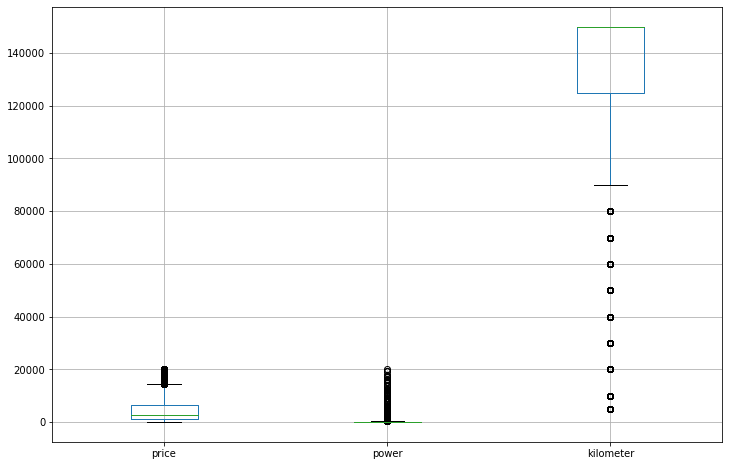

In [22]:
fig = plt.subplots(figsize=(12, 8))
data[main_num_columns].boxplot()

In [23]:
#Избавимся от выбросов
data = data[(data['price']<=data['price'].quantile(0.80)) & (data['price']>=data['price'].quantile(0.05))]
data = data[(data['power']<=data['power'].quantile(0.95))&(data['power']>=data['power'].quantile(0.05))]
data = data[data['kilometer']>=8000]

In [24]:
round(data[main_num_columns].describe(), 1)

,price,power,kilometer
count,246136.0,246136.0,246136.0
mean,2617.8,90.6,135831.7
std,1950.4,46.2,28721.8
min,200.0,0.0,10000.0
25%,999.0,60.0,125000.0
50%,2000.0,94.0,150000.0
75%,3899.0,122.0,150000.0
max,7690.0,188.0,150000.0


,registrationyear
count,246136.000000
mean,2002.446213
std,46.949596
min,1910.000000
25%,1998.000000
50%,2002.000000
75%,2006.000000
max,9999.000000


<AxesSubplot:>

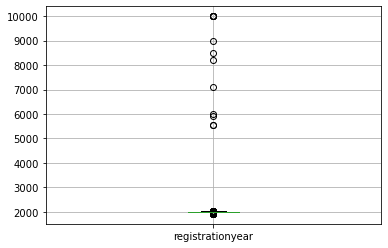

In [25]:
display(data[['registrationyear']].describe())
data[['registrationyear']].boxplot()

In [26]:
data = data[data['registrationyear']>=1960]

<AxesSubplot:>

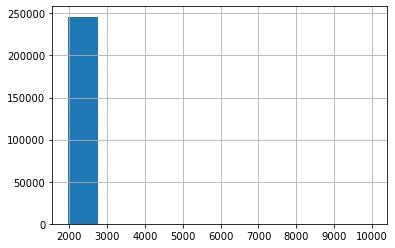

In [27]:
data['registrationyear'].hist()

In [28]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210383 entries, 0 to 210382
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             210383 non-null  int64 
 1   vehicletype       210383 non-null  object
 2   registrationyear  210383 non-null  int64 
 3   gearbox           210383 non-null  object
 4   power             210383 non-null  int64 
 5   model             210383 non-null  object
 6   kilometer         210383 non-null  int64 
 7   fueltype          210383 non-null  object
 8   brand             210383 non-null  object
 9   repaired          210383 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.1+ MB


Данные нам достались достаточно "шумные" с большим количеством пропусков. Была проведена предобработка:
- избавились от лишних столбцов, ненужных для данного исследования
- для столбца ремонта поставлена заглушка 'nda', что соответствует маркировке 'нет данных'
- в столбце `fueltype` пропуски заполнены самым популярным топливом
- в столбце `vehicletype` пропуски заменены на популярный тип кузова каждой модели
- остальные пропуски были удалены, поскольку подобрать достоверно значения не представляется возможным и столбцы являются ключевыми для оценки стоимости
- проведена очистка данных от выбросов
- данные очищены от дубликатов

В конечном итоге для дальнейшей работы осталось около 60% данных от исходного датасета.

In [29]:
data.describe()

,price,registrationyear,power,kilometer
count,210383.000000,210383.000000,210383.000000,210383.000000
mean,2646.824553,2002.585375,90.860378,134858.686301
std,1962.729839,50.722545,46.571556,29533.186729
min,200.000000,1960.000000,0.000000,10000.000000
25%,1000.000000,1998.000000,61.000000,125000.000000
50%,2000.000000,2002.000000,95.000000,150000.000000
75%,3900.000000,2006.000000,125.000000,150000.000000
max,7690.000000,9999.000000,188.000000,150000.000000



## Обучение моделей

In [30]:
# Разделим выборку на целевую и признак
features=data.drop(['price'],axis=1)
target=data['price']
random_state=254

In [31]:
train_features, valid_features, train_target, valid_target = train_test_split(
    features,target, test_size=0.4, random_state=random_state)

test_features, valid_features, test_target, valid_target = train_test_split(
    valid_features,valid_target, test_size=0.5, random_state=random_state)

In [32]:
print('Размер тренировочной выборки:')
print(train_features.shape)
print(train_target.shape)
print()
print('Размер валидационной выборки:')
print(valid_features.shape)
print(valid_target.shape)
print()
print('Размер тестовой выборки:')
print(test_features.shape)
print(test_target.shape)

Размер тренировочной выборки:
(126229, 9)
(126229,)

Размер валидационной выборки:
(42077, 9)
(42077,)

Размер тестовой выборки:
(42077, 9)
(42077,)


In [33]:
train_features

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
108439,wagon,2006,auto,140,passat,150000,gasoline,volkswagen,no
108637,sedan,1999,manual,60,clio,150000,petrol,renault,no
181368,sedan,1997,manual,110,golf,150000,gasoline,volkswagen,yes
158946,small,1999,manual,102,3er,150000,petrol,bmw,nda
190581,small,2004,manual,60,ka,100000,petrol,ford,yes
...,...,...,...,...,...,...,...,...,...
87047,convertible,2004,manual,90,tigra,50000,petrol,opel,no
164422,suv,2000,manual,120,freelander,150000,petrol,land_rover,no
182378,wagon,2001,manual,118,focus,150000,gasoline,ford,no
83753,small,2000,auto,0,fortwo,125000,petrol,smart,no


In [34]:
# Применим кодировку для категориальных данных
col=['vehicletype', 'gearbox','model',
       'fueltype', 'brand', 'repaired']
encoder = OrdinalEncoder()
train_features_enc = train_features.copy()
train_features_enc[col] = encoder.fit_transform(train_features[col])
train_features_enc.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
108439,7.0,2006,0.0,140,169.0,150000,2.0,38.0,1.0
108637,4.0,1999,1.0,60,74.0,150000,6.0,27.0,1.0
181368,4.0,1997,1.0,110,114.0,150000,2.0,38.0,2.0
158946,5.0,1999,1.0,102,11.0,150000,6.0,2.0,0.0
190581,5.0,2004,1.0,60,126.0,100000,6.0,10.0,2.0


In [35]:
valid_features_enc = valid_features.copy()
valid_features_enc[col] = encoder.transform(valid_features_enc[col])
valid_features_enc.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
196105,4.0,1996,0.0,129,94.0,150000,2.0,20.0,1.0
31711,5.0,1997,2.0,0,74.0,150000,6.0,27.0,0.0
68724,5.0,2005,1.0,58,86.0,125000,6.0,8.0,1.0
84910,7.0,2001,0.0,179,31.0,150000,2.0,1.0,0.0
20744,7.0,2008,0.0,136,94.0,150000,2.0,20.0,1.0


In [36]:
test_features_enc = test_features.copy()
try:
    test_features_enc[col] = encoder.transform(test_features_enc[col])  
except:
    test_features_enc = test_features_enc[test_features_enc['model'].isin(train_features['model'])]
    test_features_enc[col] = encoder.transform(test_features_enc[col])
    test_target = test_target[test_target.index.isin(test_features_enc.index)]
test_features_enc.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
83068,4.0,1999,1.0,75,114.0,150000,6.0,38.0,0.0
96203,5.0,2004,1.0,77,121.0,150000,6.0,11.0,1.0
74560,1.0,2002,1.0,109,8.0,150000,6.0,25.0,1.0
147521,4.0,2004,1.0,105,42.0,150000,6.0,24.0,1.0
39456,4.0,1995,1.0,90,114.0,150000,6.0,38.0,1.0


In [37]:
# функция целевой метрики
def rmse_mae(target,predict):
    mae = mean_absolute_error(target, predict)
    rmse = (mean_squared_error(target,predict, squared = False)).round(2)
    return mae, rmse

In [38]:
# Модель Дерево решений
start_time = time.time()
model_DTR = DecisionTreeRegressor()
parametrs = { 'max_depth': range(1,10),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10) 
            }

grid_1 = GridSearchCV(model_DTR, parametrs, scoring='neg_root_mean_squared_error', cv=7, n_jobs =-1)
model_1 = grid_1.fit(train_features_enc,train_target)
finish_time = time.time()
train_time_1 = round(finish_time-start_time, 2)
print('Модель DecisionTreeRegressor ')
print ("Расчетное время обучения", train_time_1)

start_time = time.time()
predict_1= model_1.predict(valid_features_enc)
finish_time = time.time()
predict_time_1=round(finish_time-start_time, 2)
print ("Расчетное время  передсказания", predict_time_1)
print('Гиперпараметры модели:\n',grid_1)
print()
mae_1, rmse_1 = rmse_mae(valid_target, predict_1)
print('MAE',mae_1)
print('RMSE',rmse_1)

Модель DecisionTreeRegressor 
Расчетное время обучения 349.76
Расчетное время  передсказания 0.02
Гиперпараметры модели:
 GridSearchCV(cv=7, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             scoring='neg_root_mean_squared_error')

MAE 835.0273642160059
RMSE 1131.41


In [39]:
# Модель Случайных дров
start_time = time.time()
model_RF = RandomForestRegressor()
parametrs = { 'n_estimators': range (1, 10),
              'max_depth': range (1,10),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10)
            }

grid_2 = GridSearchCV(model_RF, parametrs, cv=3, n_jobs =-1)
model_2 = grid_2.fit(train_features_enc,train_target)

finish_time = time.time()
train_time_2 = round(finish_time-start_time, 2)
print('Модель RandomForestRegressor ')
print ("Расчетное время обучения", train_time_2)

start_time = time.time()
predict_2 = model_2.predict(valid_features_enc)
finish_time = time.time()
predict_time_2 = round(finish_time-start_time, 2)
print ("Расчетное время  передсказания", predict_time_2)
print('Гиперпараметры модели:\n',grid_2)
print()
mae_2, rmse_2 = rmse_mae(valid_target, predict_2)
print('MAE',mae_2)
print('RMSE',rmse_2)

Модель RandomForestRegressor 
Расчетное время обучения 1727.42
Расчетное время  передсказания 0.08
Гиперпараметры модели:
 GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 8),
                         'min_samples_split': range(2, 10),
                         'n_estimators': range(1, 10)})

MAE 808.6657906196672
RMSE 1093.61


In [40]:
# Модель Градиентного Бустинга CatBoostRegressor
start_time = time.time()
model_CBR = CatBoostRegressor()
parametrs = {
            'n_estimators' : range(1,10),
            'verbose' : [0],
            'max_depth' : range(1,10)
    }
grid_3 = GridSearchCV(model_CBR, parametrs, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
model_3 = grid_3.fit(train_features_enc,train_target)
finish_time = time.time()
train_time_3 = round(finish_time-start_time, 2)
print('Модель CatBoostRegressor')
print ("Расчетное время обучения", train_time_3)

start_time = time.time()
predict_3 = model_3.predict(valid_features_enc)
finish_time = time.time()
predict_time_3 = round(finish_time-start_time, 2)
print ("Расчетное время  передсказания", predict_time_3)
print('Гиперпараметры модели:\n',grid_3)

print()
mae_3, rmse_3 = rmse_mae(valid_target, predict_3)
print('MAE',mae_3)
print('RMSE',rmse_3)

Модель CatBoostRegressor
Расчетное время обучения 21.42
Расчетное время  передсказания 0.01
Гиперпараметры модели:
 GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002CA872E9160>,
             n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 10), 'verbose': [0]},
             scoring='neg_mean_squared_error')

MAE 756.3121233053504
RMSE 1032.33


In [41]:
# Модель Градиентного Бустинга LightGBM
start_time = time.time()
model_LGBMR = LGBMRegressor()
parametrs = {'n_estimators' : range(1,10),
            'learning_rate' : [0.4],
            'max_depth' : range(-1,10)
            }

grid_4 = GridSearchCV(model_LGBMR, parametrs, cv=3, n_jobs=-1)
model_4 = grid_4.fit(train_features_enc,train_target)
finish_time = time.time()
train_time_4 = round(finish_time-start_time, 2)
print('Модель LGBMRegressor')
print ("Расчетное время обучения", train_time_4)

start_time = time.time()
predict_4 = model_4.predict(valid_features_enc)
finish_time = time.time()
predict_time_4 = round(finish_time-start_time, 2)
print ("Расчетное время передсказания", predict_time_4)
print('Гиперпараметры модели:\n',grid_4)

print()
mae_4, rmse_4 = rmse_mae(valid_target, predict_4)
print('MAE',mae_4)
print('RMSE',rmse_4)

Модель LGBMRegressor
Расчетное время обучения 22.4
Расчетное время передсказания 0.02
Гиперпараметры модели:
 GridSearchCV(cv=3, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.4], 'max_depth': range(-1, 10),
                         'n_estimators': range(1, 10)})

MAE 764.8204246050033
RMSE 1041.25


## Анализ моделей

In [106]:
columns=['RMSE','MAE']

pivot = pd.DataFrame(columns = columns
                               , index = ['DecisionTreeRegressor', 'RandomForestRegressor'
                                          ,'CatBoostRegressor','LightGBM'])
pivot['RMSE'] = rmse_1, rmse_2, rmse_3, rmse_4
pivot['MAE'] = mae_1, mae_2, mae_3, mae_4
pivot['MAE'] = round(pivot['MAE'] ,2 )
pivot['время_обучения'] = train_time_1, train_time_2, train_time_3, train_time_4
pivot['время_передсказания'] = predict_time_1, predict_time_2, predict_time_3, predict_time_4
pivot = pivot.reset_index()
pivot.columns = ['model_name','RMSE','MAE','время_обучения','время_передсказания']
pivot

,model_name,RMSE,MAE,время_обучения,время_передсказания
0,DecisionTreeRegressor,1131.41,835.03,349.76,0.02
1,RandomForestRegressor,1093.61,808.67,1727.42,0.08
2,CatBoostRegressor,1032.33,756.31,21.42,0.01
3,LightGBM,1041.25,764.82,22.40,0.02


In [107]:
best_model = pivot[pivot['MAE'] ==pivot['MAE'].min()]
best_model

,model_name,RMSE,MAE,время_обучения,время_передсказания
2,CatBoostRegressor,1032.33,756.31,21.42,0.01


In [108]:
# Проверим модели на тестовой выборке
def testing_best(model):
    predict = model.predict(test_features_enc)
    mae, rmse = rmse_mae (test_target,predict)
    return mae, rmse

In [109]:
models_name = ['DecisionTreeRegressor', 'RandomForestRegressor'
                                          ,'CatBoostRegressor','LightGBM']
model = [model_1 ,model_2, model_3, model_4]
k=0
for i in models_name:
    if  i in str(best_model['model_name'].unique()):
        print('Результаты тестирования модели', i)
        mae_best, rmse_best = testing_best(model[k])
    k=+1

print('MAE',mae_best)
print('RMSE',rmse_best)


Результаты тестирования модели CatBoostRegressor
MAE 810.6567491186083
RMSE 1098.97


По результатам подбора модели в качестве и скорости предсказания оптимальной оказалась модель CatBoostRegressor.